# Table of contents

## Testing triggers in metadata vs audio file

We test here whether there is a difference between the triggers encoded in the audio file (that is played and we get in the MEG) and the metadata.
Conclusion: no differences...


## MEG Triggers Vs the others

Now we test, for multiple runs / subjects, what is the length of the measured triggers (bad news: it's bad, the number of triggers is almost always more in the MEG than in the original audio...). Same for the length: the difference between the first and the last trigger is always longer in the MEG triggers...

## Testing the shortest event parameter

No difference in the amount of triggers, whether the shortest_event parameter is [0.001;10]


In [2]:
# Constants
from pathlib import Path

# Neuro
import mne
import mne_bids

# ML/Data
import numpy as np
import pandas as pd

# Tools
from pathlib import Path
import os
import matplotlib.pyplot as plt

from utils import get_path
from utils import (
    match_list,
    add_syntax,
    mne_events,
    decoding_from_criterion,
    get_code_path,
    get_path,
)


modality = "auditory"
subject = '2'
run_id = "01"

t7_folder = Path("/media/co/T7/workspace-LPP/data/MEG/LPP/PallierListen2023/download")

modality = 'auditory'

In [5]:
# Create a function so that we can iterate on subjects / runs

def epochs_and_match(subject, run):
    
    path = t7_folder
    task_map = {"auditory": "listen", "visual": "read", "fmri": "listen"}
    task = task_map[modality]
    print(f"\n Epoching for run {run}, subject: {subject}\n")
    run_id = '0' + str(run) 
    bids_path = mne_bids.BIDSPath(
        subject=subject,
        session="01",
        task=task,
        datatype="meg",
        root=path,
        run=run_id,
    )

    raw = mne_bids.read_raw_bids(bids_path)
    # triggers = mne.find_events(raw, stim_channel="STI101", shortest_event=1)
    triggers = mne.find_events(raw, stim_channel="STI101", shortest_event=1)

    raw.del_proj()  # To fix proj issues
    raw.pick_types(meg=True, stim=True, misc=True)
    raw.load_data()

    # Generate event_file path
    event_file = path / f"sub-{bids_path.subject}"
    event_file = event_file / f"ses-{bids_path.session}"
    event_file = event_file / "meg"
    event_file = str(event_file / f"sub-{bids_path.subject}")
    event_file += f"_ses-{bids_path.session}"
    event_file += f"_task-{bids_path.task}"
    event_file += f"_run-{bids_path.run}_events.tsv"
    assert Path(event_file).exists()

    meta = pd.read_csv(event_file, sep="\t")

    meta['start'] = meta.onset
    
    words = meta

    events_df = meta
    # Triggers from the MEG: :, 2 is the trigger value: 1 is a word, 128 is the start / end
    word_triggers = triggers[triggers[:, 2] > 1]
    
    """
    # What's the point of epoching first? Since we epoch using the metadata anyway...
    # Look further: when epoching like that, the STI channel is messed up / not aligned
    first_meg_trigger = triggers[0][0]

    def mne_events(meta):
        events = np.ones((len(meta), 3), dtype=int)
        #events[:, 0] = (meta.start*raw.info['sfreq'])
        events[:, 0] = first_meg_trigger + (meta.start*raw.info['sfreq'])
        return dict(events=events, metadata=meta.reset_index())

    raw.filter(.5, 20., n_jobs=-1)

    epochs = mne.Epochs(raw, **mne_events(meta), decim=10, tmin=-.2, tmax=.8)
    
    
    epochs.load_data()
    """
    
    events_df["word"] = meta["trial_type"].apply(
            lambda x: eval(x)["word"] if type(eval(x)) == dict else np.nan)

    decimals = 2
    triggers_delta = np.round(np.diff(word_triggers[:, 0] / raw.info["sfreq"]), decimals=decimals)  # type: ignore
    events_delta = np.round(np.diff(words.start.values), decimals=decimals)  # type: ignore
    i, j = match_list(triggers_delta, events_delta)

    assert len(i) / len(words) > 0.7, (
        error_msg_prefix
        + f"only {len(i)/len(words)} of the words were found in the triggers"
    )
    print(f"Found {len(i)/len(words)} of the words in the triggers")

    true_indices = words.iloc[j].index

    # Find the missing words df
    opposite_indices = events_df.index.difference(true_indices)
    opposite_events_df = events_df.loc[opposite_indices]


    events_df = events_df.loc[true_indices].copy()

    events_df.loc[true_indices, "start"] = (
        word_triggers[i, 0] / raw.info["sfreq"]
    )

    metadata_words = meta
    matched_words = events_df

    # Match list between the two events arrays
    idx2, idx = match_list((metadata_words.word.values), (matched_words.word.values))

    # Plot the two matched arrays
    plt.title("Trigger shift, over {len(i)}")
    plt.plot(metadata_words.start.values[idx2]- matched_words.start.values[idx])
    plt.save_fig(f'plot_shift_{run}_{subject}.png')


In [6]:
for subject in range(58):
    for run in range(1,10):
        epochs = epochs_and_match(subject, run)


 Epoching for run 1, subject: 0



TypeError: subject must be an instance of None or str, got <class 'int'> instead.

# Opening a different TextGrid file from LPP IRM

In [41]:
file = '/home/co/tmp/testing_code/1.TextGrid'



In [42]:
import textgrids as tg
import pandas as pd


textgrid = tg.TextGrid(file)


words = [interval.text for interval in (textgrid['text words']) if interval.text != ""]

In [ ]:
# Timing
words = [interval.text for interval in (textgrid['text words']) if interval.text != ""]

In [3]:
len(words)

1614

In [91]:
# TXT 2

txt2 = 643.75 - 3.11
txt3 = 698.42 - 3.06
txt4 = 620.7 - 3.07 

In [70]:
print("Duration of the trigger from MEG (first word to last word) : ", (word_triggers[-1][0] - word_triggers[0][0]) / raw.info['sfreq'])


Duration of the trigger from MEG (first word to last word) :  641.663


In [72]:
run2_triggers = word_triggers

In [76]:
run3_triggers = word_triggers

In [89]:
run4_triggers = word_triggers

In [77]:
run3_triggers

array([[159624,      0,    128],
       [159834,      0,    128],
       [160275,      0,    128],
       ...,
       [854986,      0,    128],
       [855616,      0,    128],
       [856317,      0,    128]])

In [92]:
sp2 = (run2_triggers[-1][0] - run2_triggers[0][0]) / txt2

sp3 = (run3_triggers[-1][0] - run3_triggers[0][0]) / txt3

sp4 = (run4_triggers[-1][0] - run4_triggers[0][0]) / txt4



print(sp2, sp3, sp4)

1001.5968406593407 1001.9169926369075 1001.5122322426048


In [111]:
(triggers[-1][0] - triggers[0][0]) / raw.info['sfreq']

624.55

In [104]:
(triggers[-1][0] - triggers[0][0]) / raw.info['sfreq']

621.226

In [93]:
625.497

0.0003195394228459547

In [84]:
run2_triggers[-1][0] 

908367

# Testing triggers in metadata / audio file

Exploring the audio file triggers that are sent to the MEG on the audio channel to verify if they are well-encoded in the first place, compared to the event defined in the metadata

In [ ]:
import numpy as np 

from scipy.io import wavfile

import matplotlib.pyplot as plt


# Opening the wav file for the first chapter
wav_file = '/home/co/data/neuralset/LPP_copy/PallierListen2023/download/sourcedata/stimuli/audio/ch1-3.wav'

fs, data = wavfile.read(wav_file)

# Getting the channel for the triggers encoded in the 2nd part of the wav
data = data[:,1]
data = np.round(data / 30000)

In [ ]:
indices = np.where(data == 1)[0]
# Calculate the differences between consecutive indices
differences = np.diff(data)

plus = np.where(differences == 1)[0]
minus = np.where(differences == -1)[0]

plus, minus

diffs = []
for p, m in zip(plus, minus):
    # Take the min of the substraction to see if some triggers are under 300 / 44100 s long
    diffs.append(m-p)
    

In [ ]:
np.unique(diffs)

In [ ]:
# All good

In [ ]:
diff = np.diff(data)
audio_triggers = np.where(diff == 1)[0]


In [ ]:

# Get the amount of triggers in the metadata file

file = "/home/co/sub-1_ses-01_task-listen_run-01_events.tsv"

import pandas as pd

df = pd.read_csv(file, sep='\t')

meta_triggers = df.onset

print("Number of triggers in the audio file : ", len(audio_triggers))
print("Number of triggers in the meta file : ", len(meta_triggers))


print("Length of the audio file : ", (audio_triggers[-1] - audio_triggers[0] )/ fs)
print("Length of the meta file : ", (meta_triggers.iloc[-1] - meta_triggers.iloc[0]))
      
#Number of triggers in the audio file :  1614
#Number of triggers in the meta file :  1632
#Length of the audio file :  607.15
#Length of the meta file :  607.1500000000001

# We have the same length (end - start), which is a good thing: there is no problem at this point

# We have a small difference (18 words that might have been split in the metadata file, and be only one
# trigger in the wav file...

# From the MEG triggers now

Let's try to investigate what's the difference with the triggers saved in the raw file now, that seem to be quite differents

In [5]:
# Neuro
import mne
import mne_bids

# ML/Data
import numpy as np
import pandas as pd

# Tools
from pathlib import Path
import os
import matplotlib.pyplot as plt

from utils import get_path
from utils import (
    match_list,
    add_syntax,
    mne_events,
    decoding_from_criterion,
    get_code_path,
    get_path,
)


modality = "auditory"
subject = '2'
run_id = "01"


In [6]:
from pathlib import Path
#path = Path("/media/co/T7/workspace-LPP/data/MEG/LPP/PallierListen2023/download")
path = get_path(modality)
task_map = {"auditory": "listen", "visual": "read", "fmri": "listen"}
task = task_map[modality]
print(f"\n Epoching for run {run_id}, subject: {subject}\n")
bids_path = mne_bids.BIDSPath(
    subject=subject,
    session="01",
    task=task,
    datatype="meg",
    root=path,
    run=run_id,
)

raw = mne_bids.read_raw_bids(bids_path)
# triggers = mne.find_events(raw, stim_channel="STI101", shortest_event=1)
triggers = mne.find_events(raw, stim_channel="STI101", shortest_event=1)

raw.del_proj()  # To fix proj issues
raw.pick_types(meg=True, stim=True, misc=True)
raw.load_data()

# Generate event_file path
event_file = path / f"sub-{bids_path.subject}"
event_file = event_file / f"ses-{bids_path.session}"
event_file = event_file / "meg"
event_file = str(event_file / f"sub-{bids_path.subject}")
event_file += f"_ses-{bids_path.session}"
event_file += f"_task-{bids_path.task}"
event_file += f"_run-{bids_path.run}_events.tsv"
assert Path(event_file).exists()

meta = pd.read_csv(event_file, sep="\t")

meta['start'] = meta.onset


 Epoching for run 01, subject: 2

Opening raw data file /home/co/data/LPP_MEG_auditory/sub-2/ses-01/meg/sub-2_ses-01_task-listen_run-01_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 25000 ... 659999 =     25.000 ...   659.999 secs
Ready.
Reading events from /home/co/data/LPP_MEG_auditor

<ipython-input-6-f6508f5db537>:16: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
<ipython-input-6-f6508f5db537>:16: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1647 events found
Event IDs: [  1 128]
Reading 0 ... 634999  =      0.000 ...   634.999 secs...


In [7]:
words = meta

events_df = meta
# Triggers from the MEG: :, 2 is the trigger value: 1 is a word, 128 is the start / end
word_triggers = triggers[triggers[:, 2] > 1]

## Conclusion

We find that the length of the trigger from MEG is at least one second longer than the meta file / audio file...
They are calculated by simply takign the last word trigger, 
There must be something that makes the triggers happen slower.. or 

In [69]:
print("Duration of the trigger from MEG (first word to last word) : ", (word_triggers[-1][0] - word_triggers[0][0]) / raw.info['sfreq'])


Duration of the trigger from MEG (first word to last word) :  641.663


In [58]:
print("Number of triggers in the audio file : ", len(audio_triggers))
print("Number of triggers in the meta file : ", len(meta_triggers))
print("Number of triggers in the MEG triggers : ", word_triggers.shape[0])

print('\n')

print("Duration of the audio file (s): ", (audio_triggers[-1] - audio_triggers[0] )/ fs)
print("Duration of the meta file (s): ", (meta_triggers.iloc[-1] - meta_triggers.iloc[0]))
print("Duration of the trigger from MEG (first word to last word) : ", (word_triggers[-1][0] - word_triggers[0][0]) / raw.info['sfreq'])

print('\n')

print("Time from the start of the audio to the first word IN THE TRIGGERS: ", (triggers[1,0] - triggers[0,0]) / raw.info['sfreq'])
print("Time from the start of the audio to the first word IN THE METADATA: ", meta_triggers[0] )



Number of triggers in the audio file :  635000


NameError: name 'meta_triggers' is not defined

# Trying the JR plot
make mne Epochs from from these events, (and not from trigger channel)
1. show matrix x=time from word-onset, y=single trial misc channel


In [8]:
audio_triggers = raw.get_data(picks=["MISC004"])[0,:]


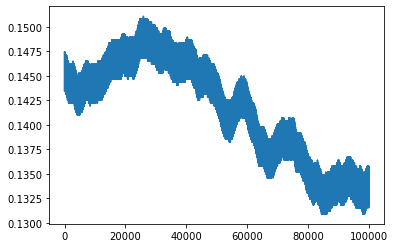

In [16]:
plt.plot(audio_triggers[:100000])

In [20]:
word_triggers = mne.find_events(raw, stim_channel="STI008", shortest_event=1)

1645 events found
Event IDs: [5]


In [21]:
word_triggers[-1] - word_triggers[0]

array([608175,      0,      0])

In [59]:
first_meg_trigger = triggers[0][0]
first_meg_trigger

42046

In [60]:
def mne_events(meta):
    events = np.ones((len(meta), 3), dtype=int)
    #events[:, 0] = (meta.start*raw.info['sfreq'])
    events[:, 0] = first_meg_trigger + (meta.start*raw.info['sfreq'])
    return dict(events=events, metadata=meta.reset_index())

In [61]:
raw.filter(.5, 20., n_jobs=-1)

epochs = mne.Epochs(raw, **mne_events(meta), decim=10, tmin=-.2, tmax=.8)
epochs 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed:    6.6s


Adding metadata with 6 columns
1632 matching events found


[Parallel(n_jobs=-1)]: Done 306 out of 306 | elapsed:    7.0s finished


Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


Number of events,1632
Events,1: 1632
Time range,-0.200 – 0.800 sec
Baseline,-0.200 – 0.000 sec


In [62]:
epochs.load_data()

Using data from preloaded Raw for 1632 events and 1001 original time points (prior to decimation) ...
0 bad epochs dropped


Number of events,1632
Events,1: 1632
Time range,-0.200 – 0.800 sec
Baseline,-0.200 – 0.000 sec


Plotting the information of for each trigger: the metadata time expected vs the time found in the triggers.

We want here, to plot:

for each epoch, basically the time when the trigger happens (1632 epochs) = find the stim channel for each epoch

vs the time when the trigger is supposed to happen (simply metadata[epochs_number]

# Studying the audio waveform in MEG, and its timings

In [12]:
epochs.plot()

<MNEBrowseFigure size 1850x1016 with 4 Axes>

In [112]:
wav_channel = "MISC004" # Each audio starts with a mini dirac before the waveform appears

start_channel = "STI001"

word_channel = "STI008"

In [37]:
start_triggers = raw.get_data(picks=["STI001"])[0,:]
indices_start = np.where(start_triggers == 5)
duration_from_001 = (indices_start[0][-1] - indices_start[0][0]) / raw.info['sfreq'] # Coudl be done better
duration_from_001

614.577

In [64]:
word_triggers = raw.get_data(picks=["STI008"])[0,:]
indices_word = np.where(word_triggers == 5)
duration_from_008 = (indices_word[0][-1] - indices_word[0][0]) / raw.info['sfreq']


In [113]:
wav_data = raw.get_data(picks=["MISC004"])[0,:]
wav_data

array([-0.00305176, -0.00244141, -0.00213623, ..., -0.00244141,
       -0.00183105, -0.00152588])

In [ ]:
# Finding onset offset of wav from MEG

In [9]:
import matplotlib
matplotlib.use('Qt5Agg')

raw.pick_types(stim=True, misc=True).plot(block=True, start=0, duration=10., precompute='auto')

Channels marked as bad:
['STI101']


<MNEBrowseFigure size 1850x1016 with 4 Axes>

In [23]:
epochs[0].get_data(picks=['STI301'], tmin=-0.1, tmax=0.1)

array([[[-1.27944946, -0.74634552, -0.21324158,  0.31986237,
          0.85296631,  1.38607025,  1.91917419,  2.45227814,
          2.98538208,  3.51848602,  4.05158997,  4.58469391,
          5.11779785,  5.65090179,  6.18400574,  6.71710968,
          7.25021362,  7.78331757,  8.31642151,  8.84952545]]])

In [82]:
epochs[153].get_data(picks=['STI101'], tmin=-0.1, tmax=0.1)

array([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]]])

In [80]:
epochs[151].get_data(picks=['STI101'])

array([[[  0., 128.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         128.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0., 128.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0., 128.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.]]])

Text(0.5, 1.0, 'Comparing the time from the supposed trigger sample to sample')

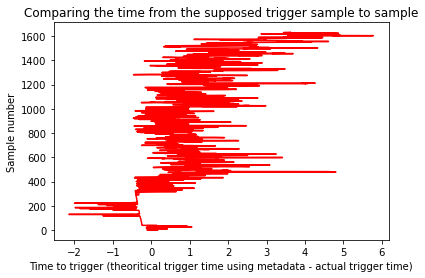

In [17]:
import matplotlib.pyplot as plt

x_to_plot = []
y_to_plot = []

for i in range(1,epochs.events.shape[0]):
    epoch = epochs[i]
    theoritical_metadata_time = epoch.events[0][0]
    trigger_time = triggers[i][0]
    x_to_plot.append((theoritical_metadata_time - trigger_time) / raw.info['sfreq'])
    y_to_plot.append(i)

plt.plot(x_to_plot[:], y_to_plot[:], 'r')
#plt.plot(trigger_time, i, color='b')
plt.xlabel("Time to trigger (theoritical trigger time using metadata - actual trigger time)")
plt.ylabel("Sample number")
plt.title("Comparing the time from the supposed trigger sample to sample")

Might want to do it by matching all the samples, as we have a diff in the number of samples... 

N_triggers_MEG > N_triggers_metadata > N_triggers_audio....

## Using the match list

Let's investigate what kind of word is removed when using the match list technique???

In [14]:
events_df["word"] = meta["trial_type"].apply(
            lambda x: eval(x)["word"] if type(eval(x)) == dict else np.nan)

decimals = 2
triggers_delta = np.round(np.diff(word_triggers[:, 0] / raw.info["sfreq"]), decimals=decimals)  # type: ignore
events_delta = np.round(np.diff(words.start.values), decimals=decimals)  # type: ignore
i, j = match_list(triggers_delta, events_delta)

assert len(i) / len(words) > 0.7, (
    error_msg_prefix
    + f"only {len(i)/len(words)} of the words were found in the triggers"
)
print(f"Found {len(i)/len(words)} of the words in the triggers")

true_indices = words.iloc[j].index

# Find the missing words df
opposite_indices = events_df.index.difference(true_indices)
opposite_events_df = events_df.loc[opposite_indices]


events_df = events_df.loc[true_indices].copy()

events_df.loc[true_indices, "start"] = (
    word_triggers[i, 0] / raw.info["sfreq"]
)

Found 0.9258578431372549 of the words in the triggers


In [16]:
meta.word

0       lorsque
1             j
2         avais
3           six
4           ans
         ...   
1627       peut
1628        pas
1629      aller
1630       bien
1631       loin
Name: word, Length: 1632, dtype: object

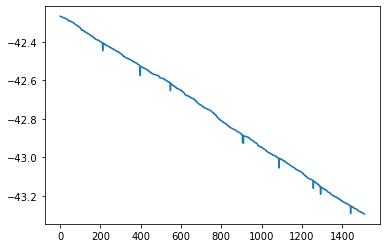

In [27]:
# Match on text the events_df df with the initial metadata, to have info how it shifts

metadata_words = meta
matched_words = events_df

# Match list between the two events arrays
idx2, idx = match_list((metadata_words.word.values), (matched_words.word.values))

# Plot the two matched arrays
plt.plot(metadata_words.start.values[idx2]- matched_words.start.values[idx])


## Words missing and their timing

Whenever we get the triggers matched, there is still the shift of 1s

In [42]:
events_df.start[-2:-1] + events_df.duration[-2:-1] - events_df.start[0] 

1629    608.015
dtype: float64

Define a function to retrieve missing words

In [43]:
def find_missing_words2(array1, array2):
    dict1 = {}
    dict2 = {}

    for word in array1:
        if word in dict1:
            dict1[word] += 1
        else:
            dict1[word] = 1

    for word in array2:
        if word in dict2:
            dict2[word] += 1
        else:
            dict2[word] = 1

    missing_words = []
    total_missing = 0
    for word in dict1:
        if word not in dict2:
            missing_words.append((word, dict1[word]))
            total_missing += dict1[word]
        elif dict1[word] > dict2[word]:
            missing_words.append((word, dict1[word] - dict2[word]))
            total_missing += dict1[word] - dict2[word]

    return missing_words, total_missing


In [44]:
all_words = words.word # Initial metadata
word_left_after_match = events_df.word # After matchlist
missing, total= find_missing_words2(words.word, word_left_after_match)

In [45]:
total, missing
# It matches perfectly with the number of words missing

(121,
 [('j', 1),
  ('avais', 3),
  ('ai', 1),
  ('un', 2),
  ('la', 3),
  ('s', 1),
  ('ça', 1),
  ('du', 10),
  (' ', 18),
  ('on', 2),
  ('les', 1),
  ('boas', 1),
  ('leur', 1),
  ('bouger', 1),
  ('de', 1),
  ('beaucoup', 1),
  ('à', 1),
  ('mon', 1),
  ('il', 1),
  ('aux', 1),
  ('je', 2),
  ('ont', 1),
  ('répondu', 1),
  ('chapeau', 1),
  ('pas', 2),
  ('éléphant', 1),
  ('que', 1),
  ('conseillé', 1),
  ('géographie', 1),
  ('histoire', 1),
  ('au', 7),
  ('est', 4),
  ('abandonné', 1),
  ('rien', 1),
  ('oeil', 1),
  ('arizona', 1),
  ('très', 2),
  ('égaré', 1),
  ('chez', 1),
  ('n', 1),
  ('lui', 1),
  ('étoiles', 1),
  ('cravates', 1),
  ('connaître', 1),
  ('parler', 1),
  ('endormi', 1),
  ('étais', 1),
  ('milieu', 1),
  ('océan', 1),
  ('mouton', 1),
  ('sérieuse', 1),
  ('ose', 1),
  ('répondit', 1),
  ('fus', 1),
  ('répondre', 1),
  ('veux', 1),
  ('dangereux', 1),
  ('encombrant', 1),
  ('cornes', 1),
  ('caisse', 1),
  ('herbe', 1),
  ('donné', 1),
  ('venait', 1

Next step: understanding which starts are linked with the words so I could see if it's regular / linked to a particular type of word / etc

To do so, let's get the indices that didn't survive match list, and get information on both:

words (confirm it's the same as previously found)

their starts: is it constant, linear, etc..

In [46]:
opposite_events_df

,Unnamed: 0,onset,duration,trial_type,start,word
37,37,17.650,0.07500,"{'kind': 'word', 'word': 'du'}",17.650,du
38,38,17.725,0.07500,"{'kind': 'word', 'word': ' '}",17.725,
61,61,27.060,0.46424,"{'kind': 'word', 'word': 'bouger'}",27.060,bouger
107,107,45.690,0.26000,"{'kind': 'word', 'word': 'ça'}",45.690,ça
115,115,48.910,0.06000,"{'kind': 'word', 'word': 'aux'}",48.910,aux
...,...,...,...,...,...,...
1563,1563,586.240,0.37000,"{'kind': 'word', 'word': 'attaches'}",586.240,attaches
1568,1568,587.340,0.39000,"{'kind': 'word', 'word': 'importe'}",587.340,importe
1572,1572,588.280,0.20000,"{'kind': 'word', 'word': 'se'}",588.280,se
1573,1573,588.480,0.45000,"{'kind': 'word', 'word': 'perdra'}",588.480,perdra


In [54]:
# Verify that they are the right words
pd.unique(opposite_events_df.word)

array(['du', ' ', 'bouger', 'ça', 'aux', 'je', 'leur', 'répondu', 'ont',
       'conseillé', 'histoire', 'au', 'abandonné', 'j', 'ai', 'la',
       'géographie', 'beaucoup', 'oeil', 'arizona', 'on', 's', 'est',
       'égaré', 'chapeau', 'lui', 'étoiles', 'de', 'cravates',
       'connaître', 'avais', 'milieu', 'océan', 'pas', 'n', 'rien', 'les',
       'boas', 'parler', 'sérieuse', 'ose', 'répondre', 'veux', 'un',
       'éléphant', 'très', 'dangereux', 'encombrant', 'mouton', 'cornes',
       'caisse', 'fus', 'herbe', 'à', 'donné', 'endormi', 'il', 'venait',
       'mon', 'étais', 'prenne', 'ajouta', 'planète', 'répondit', 'avion',
       'enfonça', 'chez', 'as', 'donnée', 'que', 'attacher', 'idée',
       'attaches', 'importe', 'se', 'perdra', 'loin'], dtype=object)

In [57]:
print(opposite_events_df.word.value_counts())
opposite_events_df.word.value_counts().sum()

            18
du          10
au           7
est          4
la           3
            ..
les          1
boas         1
sérieuse     1
ose          1
loin         1
Name: word, Length: 77, dtype: int64


121

In [48]:
opposite_indices.shape

(121,)

Text(0, 0.5, 'Difference between two starts in seconds')

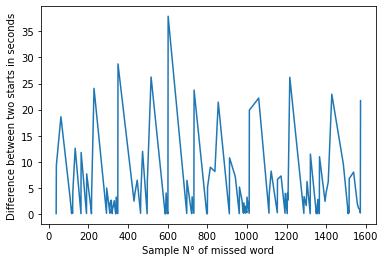

In [63]:
# Let's plot their start distribution, to see if the points are evenly 

messed_up_starts = opposite_events_df.start

plt.plot(messed_up_starts.index[:-1], np.diff(messed_up_starts))
plt.xlabel("Sample N° of missed word")
plt.ylabel("Difference between two starts in seconds")


# Problem on trigger numbers

Let's iterate on subjects and see how many triggers there are for each

In [32]:
from pathlib import Path 
def testing_nb_triggers(subject, modality="auditory", run_id=1, shortest_event=1):
    path = Path("/media/co/T7/workspace-LPP/data/MEG/LPP/PallierListen2023/download")
    task_map = {"auditory": "listen", "visual": "read", "fmri": "listen"}
    task = task_map[modality]
    print(f"\n Epoching for run {run_id}, subject: {subject}\n")
    bids_path = mne_bids.BIDSPath(
        subject=subject,
        session="01",
        task=task,
        datatype="meg",
        root=path,
        run=run_id,
    )

    raw = mne_bids.read_raw_bids(bids_path)
    # triggers = mne.find_events(raw, stim_channel="STI101", shortest_event=1)
    triggers = mne.find_events(raw, stim_channel="STI101", shortest_event=shortest_event)

    raw.del_proj()  # To fix proj issues
    raw.pick_types(meg=True, stim=False)
    raw.load_data()

    # Generate event_file path
    event_file = path / f"sub-{bids_path.subject}"
    event_file = event_file / f"ses-{bids_path.session}"
    event_file = event_file / "meg"
    event_file = str(event_file / f"sub-{bids_path.subject}")
    event_file += f"_ses-{bids_path.session}"
    event_file += f"_task-{bids_path.task}"
    event_file += f"_run-{bids_path.run}_events.tsv"
    assert Path(event_file).exists()

    meta = pd.read_csv(event_file, sep="\t")

    meta['start'] = meta.onset

    words = meta

    events_df = meta
    # Triggers from the MEG: :, 2 is the trigger value: 1 is a word, 128 is the start / end
    word_triggers = triggers[triggers[:, 2] > 1]
    
    length = (word_triggers[-1][0] - word_triggers[0][0]) / raw.info['sfreq']
    
    first_stop = (triggers[1,0] - triggers[0,0]) / raw.info['sfreq']
    
    if True:
        ## DOING THE MATCH LIST

        events_df["word"] = meta["trial_type"].apply(
                lambda x: eval(x)["word"] if type(eval(x)) == dict else np.nan)

        decimals = 2
        triggers_delta = np.round(np.diff(word_triggers[:, 0] / raw.info["sfreq"]), decimals=decimals)  # type: ignore
        events_delta = np.round(np.diff(words.start.values), decimals=decimals)  # type: ignore
        i, j = match_list(triggers_delta, events_delta)

        assert len(i) / len(words) > 0.7, (
             f"only {len(i)/len(words)} of the words were found in the triggers"
        )
        print(f"Found {len(i)/len(words)} of the words in the triggers")

        true_indices = words.iloc[j].index

        # Find the missing words df
        opposite_indices = events_df.index.difference(true_indices)
        opposite_events_df = events_df.loc[opposite_indices]


        events_df = events_df.loc[true_indices].copy()

        events_df.loc[true_indices, "start"] = (
            word_triggers[i, 0] / raw.info["sfreq"]
        )

    return word_triggers.shape[0], length, first_stop, len(i)

# Testing the shortest event

In [41]:
# Test the impact of shortest event
shortest_events = [0.01, 0.1, 1, 1.00000001, 10]
subject = '24'
nb_trigg = {}
for shortest in shortest_events:
    
    triggs, _, _ = testing_nb_triggers(subject = str(subject), shortest_event=shortest)
    nb_trigg[shortest] = triggs


 Epoching for run 1, subject: 24



AssertionError: only 0.5661764705882353 of the words were found in the triggers

In [33]:
nb_trigg

{0.01: 2148, 0.1: 2148, 1: 2148, 1.00000001: 2148, 10: 2148}

In [45]:
import mne
import logging
import mne_bids
# Set the logger level to WARNING to reduce verbosity
logger = logging.getLogger('mne')
logger.setLevel(logging.ERROR)

number_of_triggers = []
length_total = []
first_stops = []
after_matches = []

for subject in range(2,10):
    if subject == 23:
        continue
    nb_triggers, length, first, after_match = testing_nb_triggers(subject = str(subject), run_id = '02')
    number_of_triggers.append(nb_triggers)
    length_total.append(length)
    first_stops.append(first)
    after_matches.append(after_match)
    
    


 Epoching for run 02, subject: 2

Found 0.9876888640179071 of the words in the triggers

 Epoching for run 02, subject: 3

Found 0.987129266927812 of the words in the triggers

 Epoching for run 02, subject: 4

Found 0.9865696698377169 of the words in the triggers

 Epoching for run 02, subject: 5

Found 0.9904868494683827 of the words in the triggers

 Epoching for run 02, subject: 6

Found 0.9888080581980974 of the words in the triggers

 Epoching for run 02, subject: 7

Found 0.9882484611080022 of the words in the triggers

 Epoching for run 02, subject: 8

Found 0.9826524902070509 of the words in the triggers

 Epoching for run 02, subject: 9

Found 0.9854504756575265 of the words in the triggers


Now plotting the information found, iterating on the subjects, understanding:

- How many triggers are present originally

- How many are left after the match list

In [50]:
number_of_triggers

[1800, 1768, 1768, 1893, 1768, 1768, 2614, 1776]

In [51]:
after_matches

[1765, 1764, 1763, 1770, 1767, 1766, 1756, 1761]

Text(0.5, 1.0, 'Number of triggers before and after match list')

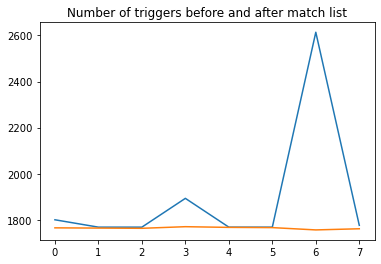

In [46]:
plt.plot(number_of_triggers)
plt.plot(after_matches)
plt.title("Number of triggers before and after match list")

Text(0.5, 1.0, 'Average time of the initial stop')

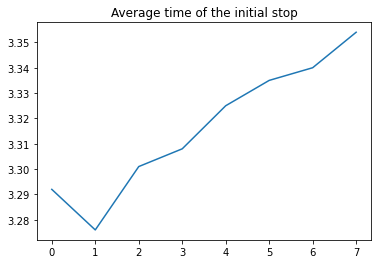

In [47]:
plt.plot(first_stops)
plt.title("Average time of the initial stop")

Text(0.5, 1.0, 'Length')

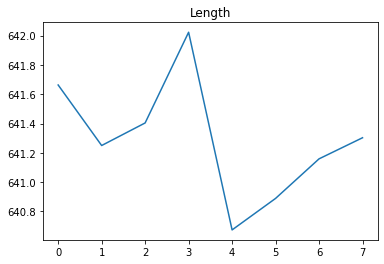

In [48]:
plt.plot(length_total)
plt.title("Length")

In [49]:
length_total

[641.663, 641.25, 641.404, 642.023, 640.674, 640.889, 641.159, 641.303]

In [29]:
_

3.211